# Scraping Jumia Ecommerce Site: DSE HACKATHON

## Import libraries

In [252]:
import requests as req
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
import os
import time
import re

import scripts.gemini_api_call as gemini_call
from scripts import scraper
import importlib

In [253]:
# # start_time = time.time()
# importlib.reload(gemini_call)
# product_cat = gemini_call.predict_product_category("Infinix Note 30 4G, 6.66"", 256GB + 8GB RAM (Dual SIM), 5000mAh, Obsidian Black")
# # end_time = time.time()
# # elapsed_time = end_time - start_time
# # elapsed_time

In [254]:
# product_cat

## Define function to fetch website html data

In [255]:
# def fetch_html_data(web_address):
#     try:
#         # print(f"\nFetching data from {web_address}...")
#         res = req.get(web_address)
#         return res
#     except req.exceptions.RequestException as e:
#         print('Stopped:', e)
#     except TypeError as e:
#         print('Stopped:', e)

# Define function to convert html data to BeautifulSoup object 

In [256]:
# def convert_web_data_to_beautiful_soup_obj(web_data):
#     try:
#         # print("Creating BeautifulSoup object...")
#         soup_obj = BeautifulSoup(web_data.text, "html.parser")
#         # print("Success! Object created!")
#         return soup_obj
#     except Exception as e:
#         print("Stopped:", e)

### Create array of products on each page, add each to product dictionary & append to array iteratively

In [257]:
all_products_list = []

def append_one_product_details_dictionary_to_list(pg):
    # print(f"Appending page {pg} products' details to array")
    
    page_products_details_soup = soup.find_all("article", class_="prd _fb col c-prd")
    
    for detail in page_products_details_soup:
        details_dict = {"name": detail.find("h3", class_="name").text.strip(),
                        "new_price": detail.find("div", class_="prc").text.strip(),
                        "old_price": detail.find("div", class_="old").text.strip() if detail.find("div", class_="old") else None,
                        "discount": detail.find("div", class_="bdg _dsct _sm").text.strip() if detail.find("div", class_="bdg _dsct _sm") else None,
                        "rating": detail.find("div", class_="stars _s").text.strip() if detail.find("div", class_="stars _s") else None,
                        "votes": detail.find("div", class_="rev").text.strip() if detail.find("div", class_="rev") else None}
        all_products_list.append(details_dict)


# len(product_details_clean)

### Fetch webdata, convert to BeautifulSoup Object, add product details dictionary to list

In [258]:
# Declare the products’ url & the total webpage count
other_pages_url = "https://www.jumia.co.ke/all-products/?page="
webpage_num_total = 50

# If scraped products csv doesn't exist, run the scraper function below & save products to csv ELSE continue & read csv
if not os.path.exists('../data/raw/all_products_list_raw.csv'):
    for page in range(1, webpage_num_total+1, 1):
        other_pages_url = "https://www.jumia.co.ke/all-products/?page="
        page = str(page)
        other_pages_url = other_pages_url + page
        response = scraper.fetch_html_data(other_pages_url)
        # time.sleep(2.5)
        soup = scraper.convert_web_data_to_beautiful_soup_obj(response)
        append_one_product_details_dictionary_to_list(page)
    
    # Convert scraped list to dataframe
    df = pd.DataFrame(all_products_list)
    # Save scraped dataframe to csv to prevent scraping each time I run the notebook
    df.to_csv('../data/raw/all_products_list_raw.csv')

### Check product count

In [259]:
# Read csv and specify index column to prevent creation of another redundant index
products_df = pd.read_csv('../data/raw/all_products_list_raw.csv', index_col=0)  # Read products list from csv

### Inspect products list dataframe

In [260]:
products_df.head()

,name,new_price,old_price,discount,rating,votes
0,Garnier Anti-Blemish Charcoal Serum With AHA +...,"KSh 1,400","KSh 1,750",20%,4.3 out of 5,4.3 out of 5(1513)
1,Garnier Even & Matte Vitamin C Booster Serum ...,KSh 850,NaN,NaN,4.2 out of 5,4.2 out of 5(778)
2,Garnier Pure Active 3 In1 Charcoal Anti Blackh...,"KSh 1,036","KSh 1,295",20%,4.4 out of 5,4.4 out of 5(4792)
3,Garnier Even & Matte Vitamin C Booster Serum ...,"KSh 1,400","KSh 1,750",20%,4.4 out of 5,4.4 out of 5(3826)
4,Garnier Bye Acne & Dark Spots Kit.,"KSh 3,608","KSh 4,245",15%,4.3 out of 5,4.3 out of 5(698)


In [261]:
products_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 0 to 1999
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       2000 non-null   object
 1   new_price  2000 non-null   object
 2   old_price  1725 non-null   object
 3   discount   1725 non-null   object
 4   rating     820 non-null    object
 5   votes      820 non-null    object
dtypes: object(6)
memory usage: 109.4+ KB


In [262]:
products_df.shape

(2000, 6)

# Data Cleaning Section

### Clean new_price column

In [263]:
products_df['new_price'][1]

'KSh 850'

In [264]:
# Remove currency name 'Ksh' 
products_df['new_price'] = products_df['new_price'].apply(lambda x: x.split(' ')[1] if x is not None and isinstance(x,str) else x) 

In [265]:
print(type(products_df['new_price'][1]))
print(products_df['new_price'].head())

<class 'str'>
0    1,400
1      850
2    1,036
3    1,400
4    3,608
Name: new_price, dtype: object


In [266]:
# Remove comma from thousands price values
products_df['new_price'] = products_df['new_price'].apply(lambda x: x.replace(',','') if ',' in x and isinstance(x,str) else x)
products_df['new_price'].head()

0    1400
1     850
2    1036
3    1400
4    3608
Name: new_price, dtype: object

In [267]:
print(type(products_df['new_price'][1]))

<class 'str'>


In [268]:
# Convert new_price column to float
products_df['new_price'] = products_df['new_price'].apply(lambda x: float(x) if x is not None else x)

In [269]:
print(type(products_df['new_price'][1]))
print(products_df['new_price'].dtype)

<class 'numpy.float64'>
float64


In [270]:
products_df.head()

,name,new_price,old_price,discount,rating,votes
0,Garnier Anti-Blemish Charcoal Serum With AHA +...,1400.0,"KSh 1,750",20%,4.3 out of 5,4.3 out of 5(1513)
1,Garnier Even & Matte Vitamin C Booster Serum ...,850.0,NaN,NaN,4.2 out of 5,4.2 out of 5(778)
2,Garnier Pure Active 3 In1 Charcoal Anti Blackh...,1036.0,"KSh 1,295",20%,4.4 out of 5,4.4 out of 5(4792)
3,Garnier Even & Matte Vitamin C Booster Serum ...,1400.0,"KSh 1,750",20%,4.4 out of 5,4.4 out of 5(3826)
4,Garnier Bye Acne & Dark Spots Kit.,3608.0,"KSh 4,245",15%,4.3 out of 5,4.3 out of 5(698)


In [271]:
# Saving stage one (new_price) data cleaning file to csv
products_df.to_csv("../data/processed/1_all_products_new_price_cleaned.csv")

### Clean old_price column

In [272]:
# Read csv file cleaned in the previous stage (new_price column) & convert to dataframe
products_df = pd.read_csv("../data/processed/1_all_products_new_price_cleaned.csv", index_col=0)

# Use [:10] notation to print the first 10 values
products_df['old_price'].unique()[:10]

array(['KSh 1,750', nan, 'KSh 1,295', 'KSh 4,245', 'KSh 850', 'KSh 3,500',
       'KSh 3,045', 'KSh 2,100', 'KSh 2,066', 'KSh 2,300'], dtype=object)

In [273]:
# Remove currency name 'Ksh'
# type(products_df['old_price'][1])
products_df['old_price'] = products_df['old_price'].apply(lambda x: x.split(' ')[1] if x is not None and isinstance(x,str) else x)
products_df['old_price'].head()

0    1,750
1      NaN
2    1,295
3    1,750
4    4,245
Name: old_price, dtype: object

In [274]:
# Remove commas from values
products_df['old_price'] = products_df['old_price'].apply(lambda x: x.replace(',','') if x is not None and isinstance(x,str) else x)
products_df['old_price'].head(10)

0    1750
1     NaN
2    1295
3    1750
4    4245
5     NaN
6     NaN
7     850
8    3500
9    3045
Name: old_price, dtype: object

In [275]:
# Convert the string values into floats
products_df['old_price'] = products_df['old_price'].apply(lambda x: float(x) if x is not None else x)
products_df['old_price'].head(10)

0    1750.0
1       NaN
2    1295.0
3    1750.0
4    4245.0
5       NaN
6       NaN
7     850.0
8    3500.0
9    3045.0
Name: old_price, dtype: float64

In [276]:
products_df['old_price']

0       1750.0
1          NaN
2       1295.0
3       1750.0
4       4245.0
         ...  
1995    1685.0
1996    6675.0
1997    2002.0
1998    1878.0
1999    1750.0
Name: old_price, Length: 2000, dtype: float64

In [277]:
# Index 18 from above was null. So checking its type: 
print(type(products_df['old_price'][18]))
print(products_df['old_price'].dtype)

<class 'numpy.float64'>
float64


In [278]:
products_df.head()

,name,new_price,old_price,discount,rating,votes
0,Garnier Anti-Blemish Charcoal Serum With AHA +...,1400.0,1750.0,20%,4.3 out of 5,4.3 out of 5(1513)
1,Garnier Even & Matte Vitamin C Booster Serum ...,850.0,NaN,NaN,4.2 out of 5,4.2 out of 5(778)
2,Garnier Pure Active 3 In1 Charcoal Anti Blackh...,1036.0,1295.0,20%,4.4 out of 5,4.4 out of 5(4792)
3,Garnier Even & Matte Vitamin C Booster Serum ...,1400.0,1750.0,20%,4.4 out of 5,4.4 out of 5(3826)
4,Garnier Bye Acne & Dark Spots Kit.,3608.0,4245.0,15%,4.3 out of 5,4.3 out of 5(698)


In [279]:
# Saving stage two data (old_price column) cleaning dataframe to csv
products_df.to_csv("../data/processed/2_all_products_old_price_cleaned.csv")

### Cleaning 'discount' column

In [280]:
# Read csv file from stage 2 (old_price column cleanup) to get dataframe
products_df = pd.read_csv("../data/processed/2_all_products_old_price_cleaned.csv", index_col=0)

# Use [:10] notation to print the first 10 values
products_df['discount'].unique()[:10]

array(['20%', nan, '15%', '24%', '23%', '7%', '56%', '36%', '4%', '10%'],
      dtype=object)

In [281]:
# Remove the percent sign
products_df['discount'] = products_df['discount'].apply(lambda x: x.replace('%','') if x is not None and isinstance(x,str) else x)
products_df['discount'].unique()

array(['20', nan, '15', '24', '23', '7', '56', '36', '4', '10', '1', '30',
       '8', '38', '43', '25', '50', '29', '28', '34', '37', '48', '33',
       '39', '46', '47', '22', '14', '44', '40', '5', '13', '18', '19',
       '42', '35', '3', '26', '21', '17', '31', '45', '49', '54', '6',
       '16', '27', '72', '11', '32', '41', '53', '51', '2', '52', '61',
       '9', '57', '60', '12', '64', '69'], dtype=object)

In [282]:
# Convert values into float & divide by 100 to represent the percentages as decimal values
products_df['discount'] = products_df['discount'].apply(lambda x: float(x)/100 if x is not None else x)
products_df['discount'].unique()  # A numbers now floats and None replaced with NaN

array([0.2 ,  nan, 0.15, 0.24, 0.23, 0.07, 0.56, 0.36, 0.04, 0.1 , 0.01,
       0.3 , 0.08, 0.38, 0.43, 0.25, 0.5 , 0.29, 0.28, 0.34, 0.37, 0.48,
       0.33, 0.39, 0.46, 0.47, 0.22, 0.14, 0.44, 0.4 , 0.05, 0.13, 0.18,
       0.19, 0.42, 0.35, 0.03, 0.26, 0.21, 0.17, 0.31, 0.45, 0.49, 0.54,
       0.06, 0.16, 0.27, 0.72, 0.11, 0.32, 0.41, 0.53, 0.51, 0.02, 0.52,
       0.61, 0.09, 0.57, 0.6 , 0.12, 0.64, 0.69])

In [283]:
# Check head once more
products_df.head()

,name,new_price,old_price,discount,rating,votes
0,Garnier Anti-Blemish Charcoal Serum With AHA +...,1400.0,1750.0,0.20,4.3 out of 5,4.3 out of 5(1513)
1,Garnier Even & Matte Vitamin C Booster Serum ...,850.0,NaN,NaN,4.2 out of 5,4.2 out of 5(778)
2,Garnier Pure Active 3 In1 Charcoal Anti Blackh...,1036.0,1295.0,0.20,4.4 out of 5,4.4 out of 5(4792)
3,Garnier Even & Matte Vitamin C Booster Serum ...,1400.0,1750.0,0.20,4.4 out of 5,4.4 out of 5(3826)
4,Garnier Bye Acne & Dark Spots Kit.,3608.0,4245.0,0.15,4.3 out of 5,4.3 out of 5(698)


In [284]:
# Saving stage three data cleaning file to csv
products_df.to_csv("../data/processed/3_all_products_discount_cleaned.csv")

### Cleaning the rating column

In [285]:
# Read file cleaned in prior stage (discount column) to get dataframe
products_df = pd.read_csv("../data/processed/3_all_products_discount_cleaned.csv", index_col=0)

# Check for unique values first
products_df['rating'].unique()[:10]

array(['4.3 out of 5', '4.2 out of 5', '4.4 out of 5', '5 out of 5',
       '4 out of 5', '4.8 out of 5', '4.6 out of 5', nan, '4.5 out of 5',
       '4.7 out of 5'], dtype=object)

In [286]:
# Split rating string values into 4 elements and select the first element unless its None(left as is)
products_df['rating'] = products_df['rating'].apply(lambda x: x.split(' ')[0] if x is not None and isinstance(x,str) else x)
products_df['rating'].unique()

array(['4.3', '4.2', '4.4', '5', '4', '4.8', '4.6', nan, '4.5', '4.7',
       '4.9', '3', '4.1', '3.7', '3.8', '3.4', '3.5', '2.5', '1', '3.9',
       '2', '3.6', '3.3', '3.1', '2.7', '3.2', '2.3'], dtype=object)

In [287]:
# Convert the values into float
products_df['rating'] = products_df['rating'].apply(lambda x: float(x) if x is not None else x)
print(products_df['rating'].dtype)

float64


In [288]:
products_df.head(20)

,name,new_price,old_price,discount,rating,votes
0,Garnier Anti-Blemish Charcoal Serum With AHA +...,1400.0,1750.0,0.20,4.3,4.3 out of 5(1513)
1,Garnier Even & Matte Vitamin C Booster Serum ...,850.0,NaN,NaN,4.2,4.2 out of 5(778)
2,Garnier Pure Active 3 In1 Charcoal Anti Blackh...,1036.0,1295.0,0.20,4.4,4.4 out of 5(4792)
3,Garnier Even & Matte Vitamin C Booster Serum ...,1400.0,1750.0,0.20,4.4,4.4 out of 5(3826)
4,Garnier Bye Acne & Dark Spots Kit.,3608.0,4245.0,0.15,4.3,4.3 out of 5(698)
5,Garnier Brightening Night Serum With 10% Pure ...,2495.0,NaN,NaN,5.0,5 out of 5(10)
6,Garnier Even & Matte Dark Spot Corrector,1050.0,NaN,NaN,4.0,4 out of 5(2751)
7,L'Oreal GLYCOLIC BRIGHT FACE CLEANSER FOAM 100ML,649.0,850.0,0.24,4.8,4.8 out of 5(47)
8,Garnier Vitamin C Booster Serum 30ml Twin Pack,2975.0,3500.0,0.15,4.6,4.6 out of 5(489)
9,Garnier AHA+BHA Charcoal Serum + Pure Active 3...,2588.0,3045.0,0.15,4.4,4.4 out of 5(480)


In [289]:
# Saving stage four data cleaning file to csv
products_df.to_csv("../data/processed/4_all_products_rating_cleaned.csv")

### Cleaning the 'votes' column

In [290]:
# Read csv file saved in prior cleaning stage (rating column) to obtain dataframe
products_df = pd.read_csv("../data/processed/4_all_products_rating_cleaned.csv", index_col=0)

# Explore unique values
products_df['votes'].unique()[:10]

array(['4.3 out of 5(1513)', '4.2 out of 5(778)', '4.4 out of 5(4792)',
       '4.4 out of 5(3826)', '4.3 out of 5(698)', '5 out of 5(10)',
       '4 out of 5(2751)', '4.8 out of 5(47)', '4.6 out of 5(489)',
       '4.4 out of 5(480)'], dtype=object)

In [291]:
# Extract the votes count with string manipulation methods & convert values to floats
products_df['votes'] = products_df['votes'].apply(lambda x: float(x.split('(')[1].split(')')[0]) if x is not None and isinstance(x,str) else x)
products_df['votes'].unique()[:15]

array([1.513e+03, 7.780e+02, 4.792e+03, 3.826e+03, 6.980e+02, 1.000e+01,
       2.751e+03, 4.700e+01, 4.890e+02, 4.800e+02,       nan, 1.558e+03,
       1.000e+00, 4.070e+02, 9.000e+00])

In [292]:
products_df.head(20)

,name,new_price,old_price,discount,rating,votes
0,Garnier Anti-Blemish Charcoal Serum With AHA +...,1400.0,1750.0,0.20,4.3,1513.0
1,Garnier Even & Matte Vitamin C Booster Serum ...,850.0,NaN,NaN,4.2,778.0
2,Garnier Pure Active 3 In1 Charcoal Anti Blackh...,1036.0,1295.0,0.20,4.4,4792.0
3,Garnier Even & Matte Vitamin C Booster Serum ...,1400.0,1750.0,0.20,4.4,3826.0
4,Garnier Bye Acne & Dark Spots Kit.,3608.0,4245.0,0.15,4.3,698.0
5,Garnier Brightening Night Serum With 10% Pure ...,2495.0,NaN,NaN,5.0,10.0
6,Garnier Even & Matte Dark Spot Corrector,1050.0,NaN,NaN,4.0,2751.0
7,L'Oreal GLYCOLIC BRIGHT FACE CLEANSER FOAM 100ML,649.0,850.0,0.24,4.8,47.0
8,Garnier Vitamin C Booster Serum 30ml Twin Pack,2975.0,3500.0,0.15,4.6,489.0
9,Garnier AHA+BHA Charcoal Serum + Pure Active 3...,2588.0,3045.0,0.15,4.4,480.0


In [293]:
# Saving stage five data cleaning file to csv
products_df.to_csv("../data/processed/5_all_products_votes_cleaned.csv")

## Dealing with null values

In [294]:
# Read csv file from prior cleaning (votes column) to get dataframe
products_df = pd.read_csv("../data/processed/5_all_products_votes_cleaned.csv", index_col=0)

In [295]:
products_df.isnull().sum().idxmax()

'rating'

In [296]:
print(f"new_price nulls: {products_df.new_price.isnull().sum()}")
print(f"old_price nulls: {products_df.old_price.isnull().sum()}")
print(f"discount nulls: {products_df.discount.isnull().sum()}")
print(f"rating nulls: {products_df.rating.isnull().sum()}")
print(f"votes nulls: {products_df.votes.isnull().sum()}")

new_price nulls: 0
old_price nulls: 275
discount nulls: 275
rating nulls: 1180
votes nulls: 1180


### Fill null values in discount column 

In [297]:
# Use discount column average to fill nulls
products_df['discount'] = products_df['discount'].fillna(round(products_df['discount'].mean(), 2))
products_df.discount.isnull().sum()

0

### Fill null values in old_price based on the discount column average

In [298]:
def multiply_fill_old_price_column_nulls(row):
    new_price = row['new_price']
    discount_column_mean = round(products_df['discount'].mean(), 2)
    
    if not pd.isna(row['old_price']):
        return row['old_price']
    return new_price * discount_column_mean
        
products_df['old_price'] = products_df.apply(multiply_fill_old_price_column_nulls, axis=1)
products_df.old_price.isnull().sum()

0

### Fill rating nulls with column mean

In [299]:
products_df['rating'] = products_df['rating'].fillna(round(products_df['rating'].mean(), 2))
products_df.rating.isnull().sum()
# type(products_df['rating'][1])

0

### Fill votes nulls with column mean

In [300]:
products_df['votes'] = products_df['votes'].fillna(round(products_df['votes'].mean(), 2))
products_df.votes.isnull().sum()

0

## Rechecking nulls for all columns again

In [301]:
print(f"new_price nulls: {products_df.new_price.isnull().sum()}")
print(f"old_price nulls: {products_df.old_price.isnull().sum()}")
print(f"discount nulls: {products_df.discount.isnull().sum()}")
print(f"rating nulls: {products_df.rating.isnull().sum()}")
print(f"votes nulls: {products_df.votes.isnull().sum()}")

new_price nulls: 0
old_price nulls: 0
discount nulls: 0
rating nulls: 0
votes nulls: 0


In [302]:
products_df.head(10)

,name,new_price,old_price,discount,rating,votes
0,Garnier Anti-Blemish Charcoal Serum With AHA +...,1400.0,1750.0,0.20,4.3,1513.0
1,Garnier Even & Matte Vitamin C Booster Serum ...,850.0,289.0,0.34,4.2,778.0
2,Garnier Pure Active 3 In1 Charcoal Anti Blackh...,1036.0,1295.0,0.20,4.4,4792.0
3,Garnier Even & Matte Vitamin C Booster Serum ...,1400.0,1750.0,0.20,4.4,3826.0
4,Garnier Bye Acne & Dark Spots Kit.,3608.0,4245.0,0.15,4.3,698.0
5,Garnier Brightening Night Serum With 10% Pure ...,2495.0,848.3,0.34,5.0,10.0
6,Garnier Even & Matte Dark Spot Corrector,1050.0,357.0,0.34,4.0,2751.0
7,L'Oreal GLYCOLIC BRIGHT FACE CLEANSER FOAM 100ML,649.0,850.0,0.24,4.8,47.0
8,Garnier Vitamin C Booster Serum 30ml Twin Pack,2975.0,3500.0,0.15,4.6,489.0
9,Garnier AHA+BHA Charcoal Serum + Pure Active 3...,2588.0,3045.0,0.15,4.4,480.0


In [303]:
products_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 0 to 1999
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       2000 non-null   object 
 1   new_price  2000 non-null   float64
 2   old_price  2000 non-null   float64
 3   discount   2000 non-null   float64
 4   rating     2000 non-null   float64
 5   votes      2000 non-null   float64
dtypes: float64(5), object(1)
memory usage: 109.4+ KB


In [304]:
# Saving stage 6 data cleaning file to csv
products_df.to_csv("../data/processed/6_all_products_all_columns_cleaned.csv")

### Slice original dataframe to create an experimental dataframe 
#### (to test insertion of predicted product categories before predicting & inserting into larger product dataframe)

In [305]:
experiment_df = pd.read_csv("../data/processed/6_all_products_all_columns_cleaned.csv", index_col=0)
new_experiment_df = experiment_df.iloc[0:20]
new_experiment_df

,name,new_price,old_price,discount,rating,votes
0,Garnier Anti-Blemish Charcoal Serum With AHA +...,1400.0,1750.00,0.20,4.30,1513.0
1,Garnier Even & Matte Vitamin C Booster Serum ...,850.0,289.00,0.34,4.20,778.0
2,Garnier Pure Active 3 In1 Charcoal Anti Blackh...,1036.0,1295.00,0.20,4.40,4792.0
3,Garnier Even & Matte Vitamin C Booster Serum ...,1400.0,1750.00,0.20,4.40,3826.0
4,Garnier Bye Acne & Dark Spots Kit.,3608.0,4245.00,0.15,4.30,698.0
5,Garnier Brightening Night Serum With 10% Pure ...,2495.0,848.30,0.34,5.00,10.0
6,Garnier Even & Matte Dark Spot Corrector,1050.0,357.00,0.34,4.00,2751.0
7,L'Oreal GLYCOLIC BRIGHT FACE CLEANSER FOAM 100ML,649.0,850.00,0.24,4.80,47.0
8,Garnier Vitamin C Booster Serum 30ml Twin Pack,2975.0,3500.00,0.15,4.60,489.0
9,Garnier AHA+BHA Charcoal Serum + Pure Active 3...,2588.0,3045.00,0.15,4.40,480.0


In [306]:
# Reload the gemini api call module, 'gemini_call', to refresh/reload it before use to prevent any unusual errors
importlib.reload(gemini_call)

# Function to get the product category
def fetch_product_category(product_name):
    # Timed the API roundtrip during testing to find the average time...
    # ... to check if it's possible to surpass the set rate limit of 60 requests per min (RPM)...
    # ... besides, while doing the average time testing, I put a 1.2 sec sleep timer...
    # ... as the last line function as initial guard to ensure 50RPM aren't exceeded (60 secs/1.2 secs)
    start_time = time.time()  # Roundtrip timer start
    predicted_product_category = gemini_call.predict_product_category(product_name)
    end_time = time.time()  # Roundtrip timer stop
    durations_list.append(end_time - start_time)  # Append roundtrip time value to list

    # Commented out the sleep timer below after calculating the average roundtrip api call time is: 1.5-3.0 seconds, hence 60 RPM shall not be exceeded 
    # time.sleep(1.2)
    return predicted_product_category

# Only run the API call to create product_category col & fill it if it's not yet created
if not os.path.exists('../data/processed/7_new_experiment_df_with_product_category.csv'):
    durations_list = []  # Store api roundtrip times to be used in calculating average time during test
    # product_category_column_inserted = False  # Boolean flag to define existence status of product_category column
    for idx, row in new_experiment_df.iterrows():
        name_of_product = row["name"]  # Get current row's product name
        
        predicted_category = fetch_product_category(name_of_product)
        
        # If the 'product_category' column hasn't been inserted, insert it at index_col 1 after 'name' column
        if 'product_category' not in new_experiment_df.columns:
            print(f"{name_of_product} = {predicted_category}")
            new_experiment_df.insert(1, "product_category", predicted_category)  # Insert new column 'product_category' at index_col 1 & insert 1st value
        else:
            print(f"{name_of_product} = {predicted_category}")
            new_experiment_df.at[idx, "product_category"] = predicted_category  # Assign subsequent predicted categories to their corresponding idx positions
    
    # Print average duration of API call
    average_api_call_roundtrip_time = sum(durations_list)/len(durations_list)
    print(f"The AVERAGE API call roundtrip TIME is: {average_api_call_roundtrip_time}")
    
    # Save the dataframe with product categories into csv to avoid making expensive api call
    new_experiment_df.to_csv("../data/processed/7_new_experiment_df_with_product_category.csv")
    print(new_experiment_df)
else:
    new_experiment_df = pd.read_csv("../data/processed/7_new_experiment_df_with_product_category.csv", index_col=0)
    print(new_experiment_df)

                                                 name   product_category  \
0   Garnier Anti-Blemish Charcoal Serum With AHA +...    Health & Beauty   
1   Garnier Even & Matte  Vitamin C Booster Serum ...    Health & Beauty   
2   Garnier Pure Active 3 In1 Charcoal Anti Blackh...    Health & Beauty   
3   Garnier Even & Matte  Vitamin C Booster Serum ...    Health & Beauty   
4                  Garnier Bye Acne & Dark Spots Kit.    Health & Beauty   
5   Garnier Brightening Night Serum With 10% Pure ...    Health & Beauty   
6            Garnier Even & Matte Dark Spot Corrector    Health & Beauty   
7    L'Oreal GLYCOLIC BRIGHT FACE CLEANSER FOAM 100ML    Health & Beauty   
8      Garnier Vitamin C Booster Serum 30ml Twin Pack    Health & Beauty   
9   Garnier AHA+BHA Charcoal Serum + Pure Active 3...    Health & Beauty   
10  Red Berry RSF810 Insulated Double Wall Vacuum ...  Garden & Outdoors   
11               Maybelline Lasting Fix Setting Spray    Health & Beauty   
12          

#### Read csv with all cleaned columns (2000 row dataframe)

In [307]:
# Read csv where all columns are cleaned before fetching product categories for all 2000 product names
products_df = pd.read_csv("../data/processed/6_all_products_all_columns_cleaned.csv", index_col=0)

### Generate product categories for all 2000 product names using GEMINI API generative AI 

In [308]:
# Reload the gemini api call module, 'gemini_call', to refresh/reload it before use to prevent any unusual errors
importlib.reload(gemini_call)

# Function to get the product category
def fetch_product_category(product_name):
    # Timed the API roundtrip during testing to find the average time...
    # ... to check if it's possible to surpass the set rate limit of 60 requests per min (RPM)...
    # ... besides, while doing the average time testing, I put a 1.2 sec sleep timer...
    # ... as the last line function as initial guard to ensure 50RPM aren't exceeded (60 secs/1.2 secs)
    start_time = time.time()  # Roundtrip timer start
    predicted_product_category = gemini_call.predict_product_category(product_name)
    end_time = time.time()  # Roundtrip timer stop
    durations_list.append(end_time - start_time)  # Append roundtrip time value to list

    return predicted_product_category

# Only run the API call to create product_category col & fill it if it's not yet created
if not os.path.exists('../data/processed/8_products_df_with_product_category.csv'):
    durations_list = []  # Store api roundtrip times to be used in calculating average time during test
    # product_category_column_inserted = False  # Boolean flag to define existence status of product_category column
    for idx, row in products_df.iterrows():
        name_of_product = row["name"]  # Get current row's product name
        
        predicted_category = fetch_product_category(name_of_product)
        
        # If the 'product_category' column hasn't been inserted, insert it at index_col 1 after 'name' column
        if 'product_category' not in products_df.columns:
            print(f"{name_of_product} = {predicted_category}")
            products_df.insert(1, "product_category", predicted_category)  # Insert new column 'product_category' at index_col 1 & insert 1st value
        else:
            print(f"{name_of_product} = {predicted_category}")
            products_df.at[idx, "product_category"] = predicted_category  # Assign subsequent predicted categories to their corresponding idx positions
    
    # Save the dataframe with product categories into csv to avoid making expensive api call
    products_df.to_csv("../data/processed/8_products_df_with_product_category.csv")
    # print(products_df)
    print(f"Number of API calls made: {len(durations_list)}")
    
    # Print average duration of API call
    average_api_call_roundtrip_time = sum(durations_list)/len(durations_list)
    print(f"The AVERAGE API call roundtrip TIME is: {average_api_call_roundtrip_time}")

products_df = pd.read_csv("../data/processed/8_products_df_with_product_category.csv", index_col=0)
products_df.head(20)

Garnier Anti-Blemish Charcoal Serum With AHA + BHA & Niacinamide For Acne Prone Skin = Health & Beauty
Garnier Even & Matte  Vitamin C Booster Serum 15ml = Health & Beauty
Garnier Pure Active 3 In1 Charcoal Anti Blackhead Mask Wash Scrub -150ml = Health & Beauty
Garnier Even & Matte  Vitamin C Booster Serum 30ml. = Health & Beauty
Garnier Bye Acne & Dark Spots Kit. = Health & Beauty
Garnier Brightening Night Serum With 10% Pure Vitamin C = Health & Beauty
Garnier Even & Matte Dark Spot Corrector = Health & Beauty
L'Oreal GLYCOLIC BRIGHT FACE CLEANSER FOAM 100ML = Health & Beauty
Garnier Vitamin C Booster Serum 30ml Twin Pack = Health & Beauty
Garnier AHA+BHA Charcoal Serum + Pure Active 3-in-1 Charcoal Mask = Health & Beauty
Red Berry RSF810 Insulated Double Wall Vacuum Bottle – 700ml - Black = Home & Office
Maybelline Lasting Fix Setting Spray = Health & Beauty
Boma SANDWICH TOASTER BM-722 = Home & Office
Maybelline Fit Me Mattifying Primer Matte And Poreless = Health & Beauty
Campo V

,name,product_category,new_price,old_price,discount,rating,votes
0,Garnier Anti-Blemish Charcoal Serum With AHA +...,Health & Beauty,1400.0,1750.00,0.20,4.30,1513.0
1,Garnier Even & Matte Vitamin C Booster Serum ...,Health & Beauty,850.0,289.00,0.34,4.20,778.0
2,Garnier Pure Active 3 In1 Charcoal Anti Blackh...,Health & Beauty,1036.0,1295.00,0.20,4.40,4792.0
3,Garnier Even & Matte Vitamin C Booster Serum ...,Health & Beauty,1400.0,1750.00,0.20,4.40,3826.0
4,Garnier Bye Acne & Dark Spots Kit.,Health & Beauty,3608.0,4245.00,0.15,4.30,698.0
5,Garnier Brightening Night Serum With 10% Pure ...,Health & Beauty,2495.0,848.30,0.34,5.00,10.0
6,Garnier Even & Matte Dark Spot Corrector,Health & Beauty,1050.0,357.00,0.34,4.00,2751.0
7,L'Oreal GLYCOLIC BRIGHT FACE CLEANSER FOAM 100ML,Health & Beauty,649.0,850.00,0.24,4.80,47.0
8,Garnier Vitamin C Booster Serum 30ml Twin Pack,Health & Beauty,2975.0,3500.00,0.15,4.60,489.0
9,Garnier AHA+BHA Charcoal Serum + Pure Active 3...,Health & Beauty,2588.0,3045.00,0.15,4.40,480.0


#### Check the info() of the dataframe with product_category column

In [309]:
products_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              2000 non-null   object 
 1   product_category  2000 non-null   object 
 2   new_price         2000 non-null   float64
 3   old_price         2000 non-null   float64
 4   discount          2000 non-null   float64
 5   rating            2000 non-null   float64
 6   votes             2000 non-null   float64
dtypes: float64(5), object(2)
memory usage: 125.0+ KB


#### Checking rows with nulls in the product_category column 

In [310]:
# # The nulls are found to be sex toys as shown in the sliced dataframe below
# product_cat_empty_df = products_df[pd.isna(products_df['product_category'])]
# product_cat_empty_df

#### Filling product_category nulls with GEMINI api call with safety set to minimum (Ensure response not blocked)

In [311]:
# # Refresh gemini_call library
# importlib.reload(gemini_call)
# 
# # Slice dataframe from the main one having the empty product category
# product_category_empty_rows_df = products_df[pd.isna(products_df['product_category'])]
# 
# # Get indexes with the nulls in the sliced dataframe
# product_category_empty_rows_indexes = product_category_empty_rows_df.index
# 
# # Add IF-condition to only allow for loop to fill dataframe if nulls exist
# if products_df['product_category'].isnull().any():
#     for idx, row in product_category_empty_rows_df.iterrows():
#         name_of_product = row["name"]  # Get rows with missing product category names
#     
#         predicted_category = gemini_call.predict_product_category(name_of_product)  # Make API call to fetch the product category
#     
#         products_df.at[idx, "product_category"] = predicted_category  # Assign subsequent predicted categories to their corresponding idx positions
# 


#### Confirm rows with missing product categories have been filled

In [312]:
# # # Slice main dataframe to access the indexes where product categories were empty to view if the product category filling is successful
# empty_product_category_rows_filled_df = products_df.iloc[product_category_empty_rows_indexes]
# empty_product_category_rows_filled_df

#### Check summary info() of the production products dataframe

In [313]:
# products_df.info()

### Assign cleaned dataframe with product_category into a final csv

In [314]:
# Read csv of the final processed data folder into dataframe
products_df = pd.read_csv("../data/processed/8_products_df_with_product_category.csv", index_col=0)
products_df.head()

# Save the cleaned dataframe as a CSV in the final data folder
products_df.to_csv("../data/final/products_df_all_cleaned.csv")

In [315]:
# Rename the products_df to products_clean_df before the data analysis section
products_clean_df = pd.read_csv("../data/final/products_df_all_cleaned.csv", index_col=0)
products_clean_df.head()

,name,product_category,new_price,old_price,discount,rating,votes
0,Garnier Anti-Blemish Charcoal Serum With AHA +...,Health & Beauty,1400.0,1750.0,0.20,4.3,1513.0
1,Garnier Even & Matte Vitamin C Booster Serum ...,Health & Beauty,850.0,289.0,0.34,4.2,778.0
2,Garnier Pure Active 3 In1 Charcoal Anti Blackh...,Health & Beauty,1036.0,1295.0,0.20,4.4,4792.0
3,Garnier Even & Matte Vitamin C Booster Serum ...,Health & Beauty,1400.0,1750.0,0.20,4.4,3826.0
4,Garnier Bye Acne & Dark Spots Kit.,Health & Beauty,3608.0,4245.0,0.15,4.3,698.0


# DATA VISUALIZATION SECTION

### Summary stats of the data

In [316]:
summary_stats = products_clean_df.describe()
summary_stats

,new_price,old_price,discount,rating,votes
count,2.000000e+03,2.000000e+03,2000.00000,2000.000000,2000.000000
mean,4.052489e+03,5.852846e+03,0.34377,4.148700,40.699000
std,3.309283e+04,6.016944e+04,0.12612,0.627216,178.916338
min,2.000000e+01,6.800000e+00,0.01000,1.000000,1.000000
25%,6.000000e+02,7.115000e+02,0.28000,4.150000,4.000000
50%,1.262500e+03,1.600000e+03,0.34000,4.150000,40.700000
75%,2.778000e+03,3.830500e+03,0.45000,4.150000,40.700000
max,1.362420e+06,2.592000e+06,0.72000,5.000000,4792.000000


### Deriving the correlation matrix

In [317]:
# Returning correlation matrix for only the numerical columns
correlation_matrix = products_clean_df.corr(method='pearson', numeric_only=True)
# correlation_matrix.to_csv("results/datafiles/pearson_correlation.csv")
correlation_matrix

,new_price,old_price,discount,rating,votes
new_price,1.000000,0.989259,-0.018548,-0.002855,-0.000423
old_price,0.989259,1.000000,0.008184,-0.003160,-0.000408
discount,-0.018548,0.008184,1.000000,-0.037932,-0.037260
rating,-0.002855,-0.003160,-0.037932,1.000000,0.017221
votes,-0.000423,-0.000408,-0.037260,0.017221,1.000000


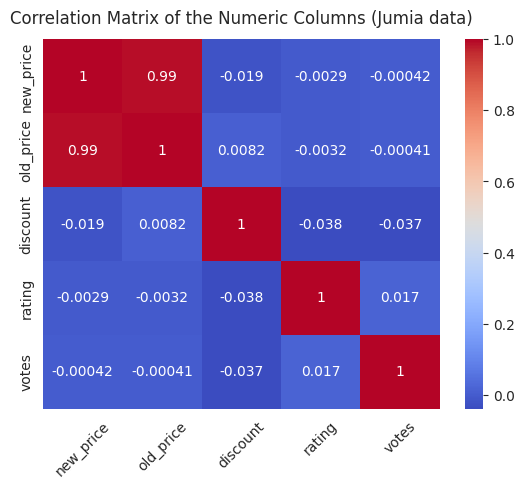

In [318]:
plt.xticks(np.arange(len(products_clean_df.columns)), products_clean_df.columns, rotation=45)
plt.yticks(np.arange(len(products_clean_df.columns)), products_clean_df.columns, rotation=45)

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of the Numeric Columns (Jumia data)', y=1.02)

plt.savefig("../results/plots/1_correlation_matrix_of_Jumia_products_numeric_data.png", bbox_inches="tight",pad_inches=2)

### Visualize top-rated products with at least 200 votes

In [319]:
# First filter for products with at least 200 votes (More votes makes a product rating more reliable)
products_with_atleast_200_votes_df = products_clean_df[products_clean_df['votes'] >= 200]
products_with_atleast_200_votes_df

,name,product_category,new_price,old_price,discount,rating,votes
0,Garnier Anti-Blemish Charcoal Serum With AHA +...,Health & Beauty,1400.0,1750.0,0.20,4.3,1513.0
1,Garnier Even & Matte Vitamin C Booster Serum ...,Health & Beauty,850.0,289.0,0.34,4.2,778.0
2,Garnier Pure Active 3 In1 Charcoal Anti Blackh...,Health & Beauty,1036.0,1295.0,0.20,4.4,4792.0
3,Garnier Even & Matte Vitamin C Booster Serum ...,Health & Beauty,1400.0,1750.0,0.20,4.4,3826.0
4,Garnier Bye Acne & Dark Spots Kit.,Health & Beauty,3608.0,4245.0,0.15,4.3,698.0
6,Garnier Even & Matte Dark Spot Corrector,Health & Beauty,1050.0,357.0,0.34,4.0,2751.0
8,Garnier Vitamin C Booster Serum 30ml Twin Pack,Health & Beauty,2975.0,3500.0,0.15,4.6,489.0
9,Garnier AHA+BHA Charcoal Serum + Pure Active 3...,Health & Beauty,2588.0,3045.0,0.15,4.4,480.0
11,Maybelline Lasting Fix Setting Spray,Health & Beauty,1785.0,2100.0,0.15,4.5,1558.0
13,Maybelline Fit Me Mattifying Primer Matte And ...,Health & Beauty,1400.0,476.0,0.34,4.6,407.0


In [320]:
# Check counts of products with rating at least 4.5
top_rated_products_df = products_with_atleast_200_votes_df[products_with_atleast_200_votes_df['rating'] >= 4.5]
top_rated_products_df

,name,product_category,new_price,old_price,discount,rating,votes
8,Garnier Vitamin C Booster Serum 30ml Twin Pack,Health & Beauty,2975.0,3500.0,0.15,4.6,489.0
11,Maybelline Lasting Fix Setting Spray,Health & Beauty,1785.0,2100.0,0.15,4.5,1558.0
13,Maybelline Fit Me Mattifying Primer Matte And ...,Health & Beauty,1400.0,476.0,0.34,4.6,407.0
21,Garnier Charcoal Serum With AHA+BHA 30ml Twin ...,Health & Beauty,2975.0,3500.0,0.15,4.5,233.0
66,NIVEA Radiant & Beauty Advanced Care Lotion Fo...,Health & Beauty,912.0,1460.0,0.38,4.7,699.0
67,NIVEA Perfect & Radiant Even Tone Day And Nigh...,Health & Beauty,887.0,1560.0,0.43,4.5,2283.0
79,NIVEA MEN Deep Antibacterial Anti-Perspirant R...,Health & Beauty,651.0,1040.0,0.37,4.6,670.0


In [321]:
# Selecting only votes & rating column before plotting
new_top_rated_products_df = top_rated_products_df[['name','rating', 'votes']].reset_index(drop=True)
new_top_rated_products_df

,name,rating,votes
0,Garnier Vitamin C Booster Serum 30ml Twin Pack,4.6,489.0
1,Maybelline Lasting Fix Setting Spray,4.5,1558.0
2,Maybelline Fit Me Mattifying Primer Matte And ...,4.6,407.0
3,Garnier Charcoal Serum With AHA+BHA 30ml Twin ...,4.5,233.0
4,NIVEA Radiant & Beauty Advanced Care Lotion Fo...,4.7,699.0
5,NIVEA Perfect & Radiant Even Tone Day And Nigh...,4.5,2283.0
6,NIVEA MEN Deep Antibacterial Anti-Perspirant R...,4.6,670.0


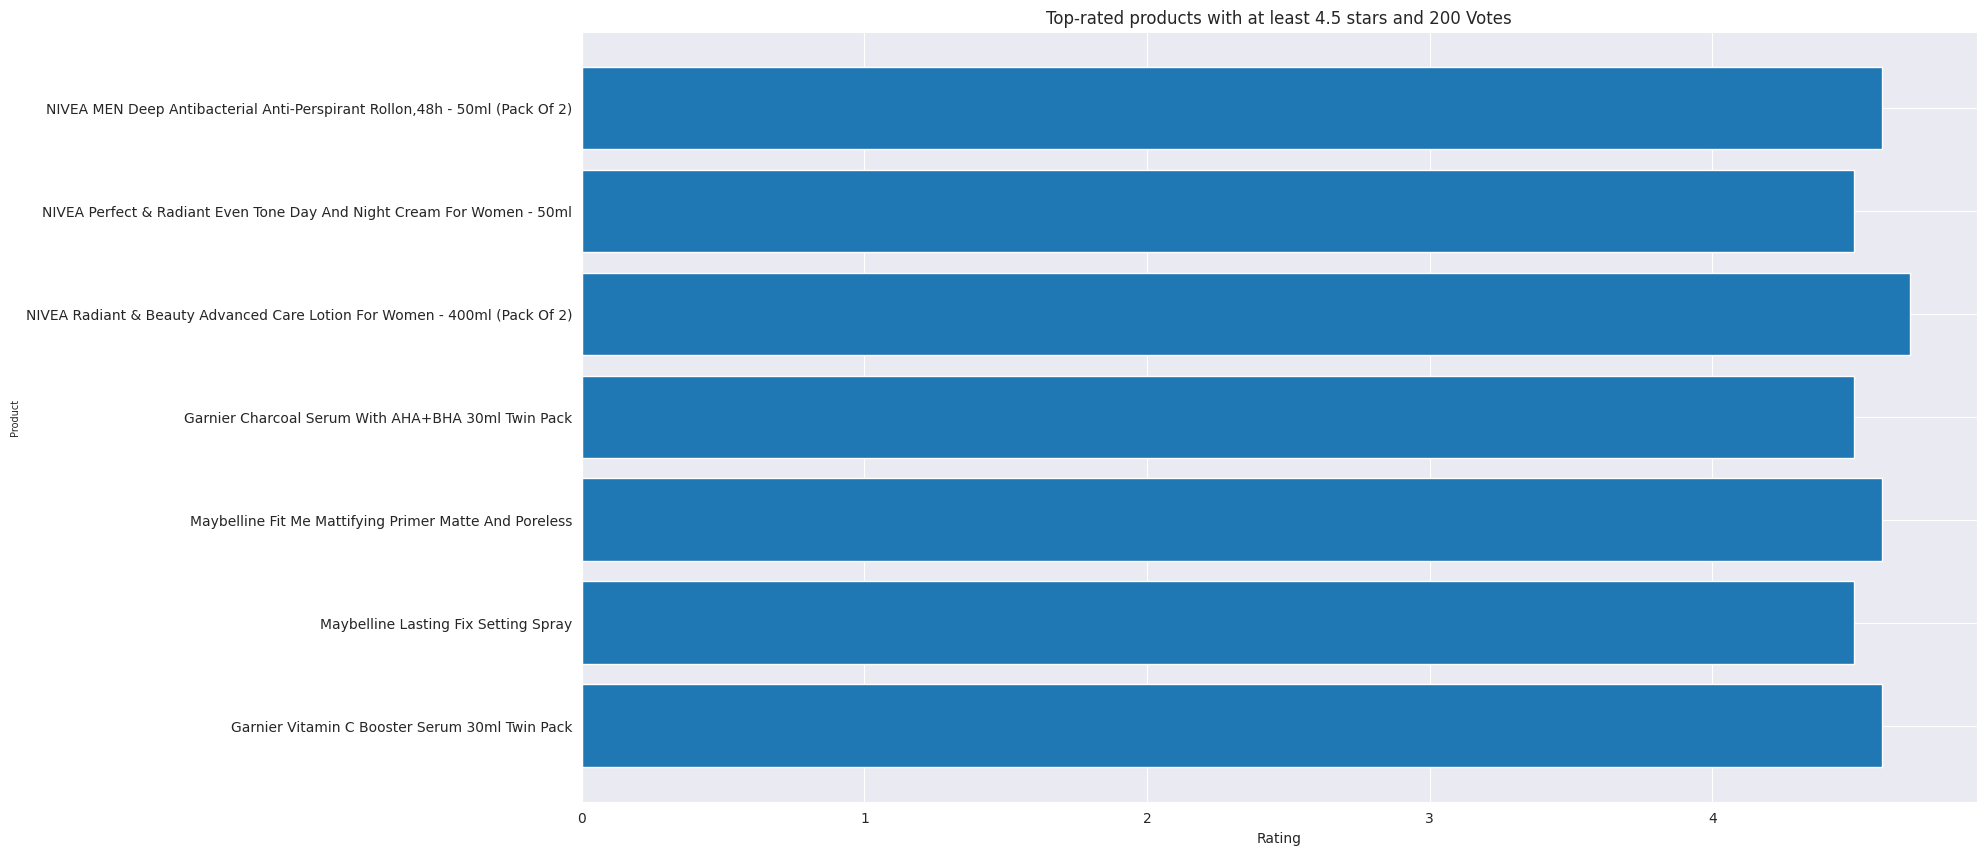

In [322]:
# Creating a horizontal bar plot
plt.figure(figsize=(18,10))

plt.barh(new_top_rated_products_df['name'], new_top_rated_products_df['rating'])

plt.title("Top-rated products with at least 4.5 stars and 200 Votes")
plt.ylabel("Product", fontsize=7)
plt.xlabel("Rating")

# Save the plot to file
plt.savefig("../results/plots/2_products_4.5_stars_and_more_than_200_votes.png",bbox_inches='tight',pad_inches=2)

### Showing product price distribution: Histogram with Kernel density estimate (kde) curve

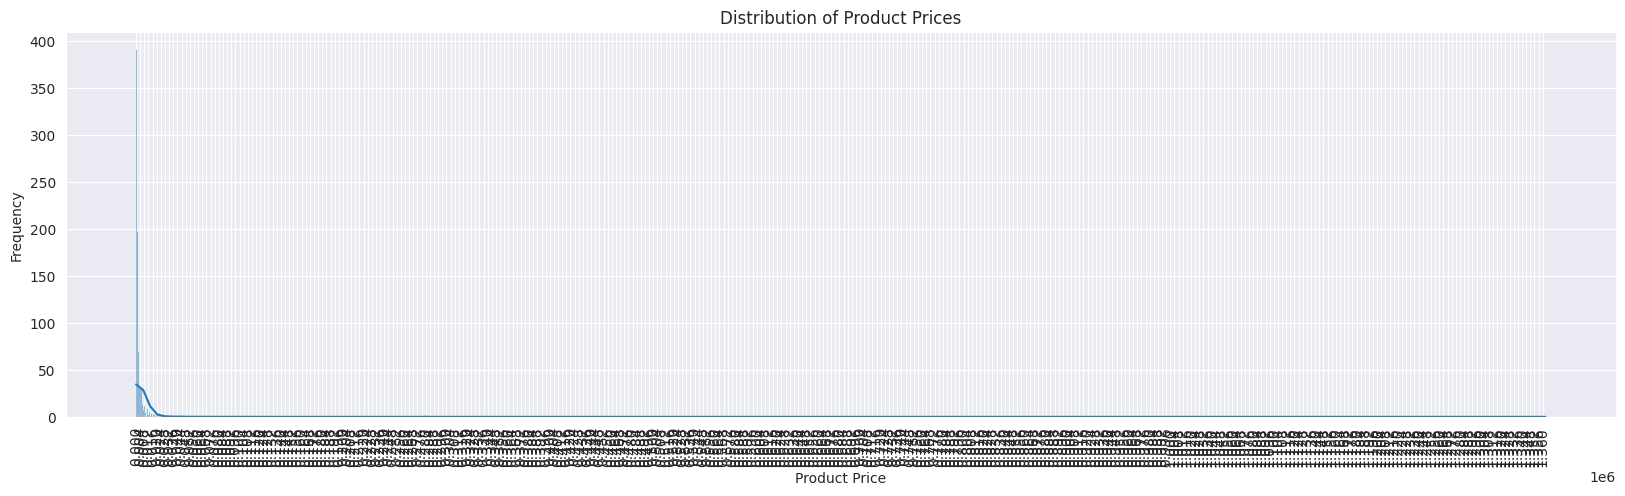

In [323]:
plt.figure(figsize=(20, 5))
sns.histplot(products_clean_df['new_price'], kde=True)
plt.xlabel('Product Price')
plt.xticks(np.arange(0, max(products_clean_df['new_price'])+1, 4000),rotation=90)
plt.ylabel('Frequency')
plt.title('Distribution of Product Prices')

# Save the plot to file
plt.savefig("../results/plots/3_product_prices_histogram_with_kernel_estimate_curve.png",bbox_inches='tight',pad_inches=1)

### Visualizing discount distribution

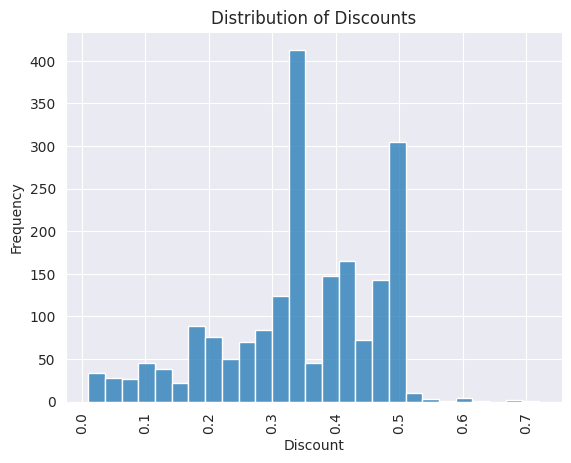

In [324]:
sns.histplot(products_clean_df['discount'])
plt.xlabel('Discount')
# plt.xticks(np.arange(0,max(products_clean_df['discount'])+1,0.5),rotation=90)
plt.xticks(rotation=90)
plt.ylabel('Frequency')
plt.title('Distribution of Discounts')

# Save the plot to file
plt.savefig("../results/plots/4_product_discount_histogram.png",bbox_inches='tight',pad_inches=1)

### Visualizing rating distribution

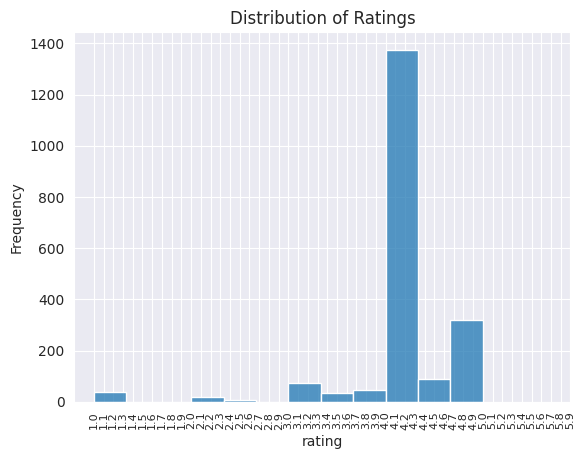

In [325]:
sns.histplot(data=products_clean_df, x='rating')
plt.title('Distribution of Ratings')
plt.xticks(np.arange(1.0, max(products_clean_df['rating'])+1, 0.1),rotation=90,fontsize=8)
plt.ylabel("Frequency")

# Save plot to file
plt.savefig("../results/plots/5_ratings_distribution_histogram.png", bbox_inches="tight", pad_inches=1)

### Product Name Analysis

In [326]:
words = ' '.join(products_clean_df['name']).split()
all_words = Counter(words)
# len(all_words)  # 4580

# Returning an array of tuples with all_words & their counts, then return first 10
all_words_counts = all_words.most_common()
all_words_counts[:10]

[('Fashion', 553),
 ('For', 240),
 ('-', 234),
 ('With', 122),
 ('Men', 108),
 ('Black', 105),
 ('&', 103),
 ('Women', 102),
 ('for', 95),
 ('Cover', 89)]

In [327]:
# Return only the alphabetical elements & their counts, & return the first 10
only_alpha_words_list = [(word, count) for word, count in all_words_counts if word.isalpha()]
only_alpha_words_list[:10]

[('Fashion', 553),
 ('For', 240),
 ('With', 122),
 ('Men', 108),
 ('Black', 105),
 ('Women', 102),
 ('for', 95),
 ('Cover', 89),
 ('Set', 87),
 ('Hair', 76)]

In [328]:
# Select the top 30 words
first_30_words = only_alpha_words_list[:31]
first_30_words

# Future: Use library to remove conjuctions such as 'and' from this list

[('Fashion', 553),
 ('For', 240),
 ('With', 122),
 ('Men', 108),
 ('Black', 105),
 ('Women', 102),
 ('for', 95),
 ('Cover', 89),
 ('Set', 87),
 ('Hair', 76),
 ('And', 71),
 ('Case', 71),
 ('Light', 70),
 ('Watch', 68),
 ('Leather', 66),
 ('Bag', 65),
 ('Car', 63),
 ('Soft', 62),
 ('Casual', 62),
 ('Wireless', 58),
 ('Ladies', 58),
 ('LED', 55),
 ('Shoes', 55),
 ('Phone', 55),
 ('Mini', 54),
 ('Bluetooth', 52),
 ('Baby', 48),
 ('High', 48),
 ('USB', 48),
 ('Cotton', 47),
 ('Oil', 46)]

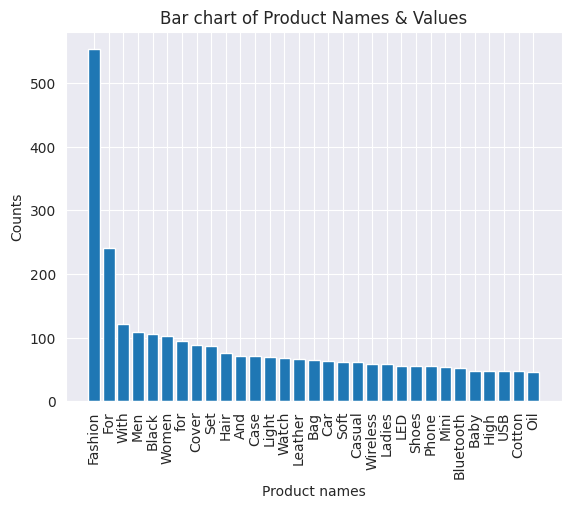

In [329]:
# Plot a chart with the first 30 words
plt.bar([d[0] for d in first_30_words], [d[1] for d in first_30_words])
plt.xlabel("Product names")
plt.xticks(rotation=90)
plt.ylabel("Counts")
plt.title("Bar chart of Product Names & Values")

# Save plot to file
plt.savefig("../results/plots/6_barchart_top_30_product_names_counts.png", bbox_inches="tight", pad_inches=1)

### Creating pairplot showing relationship between various numerical columns

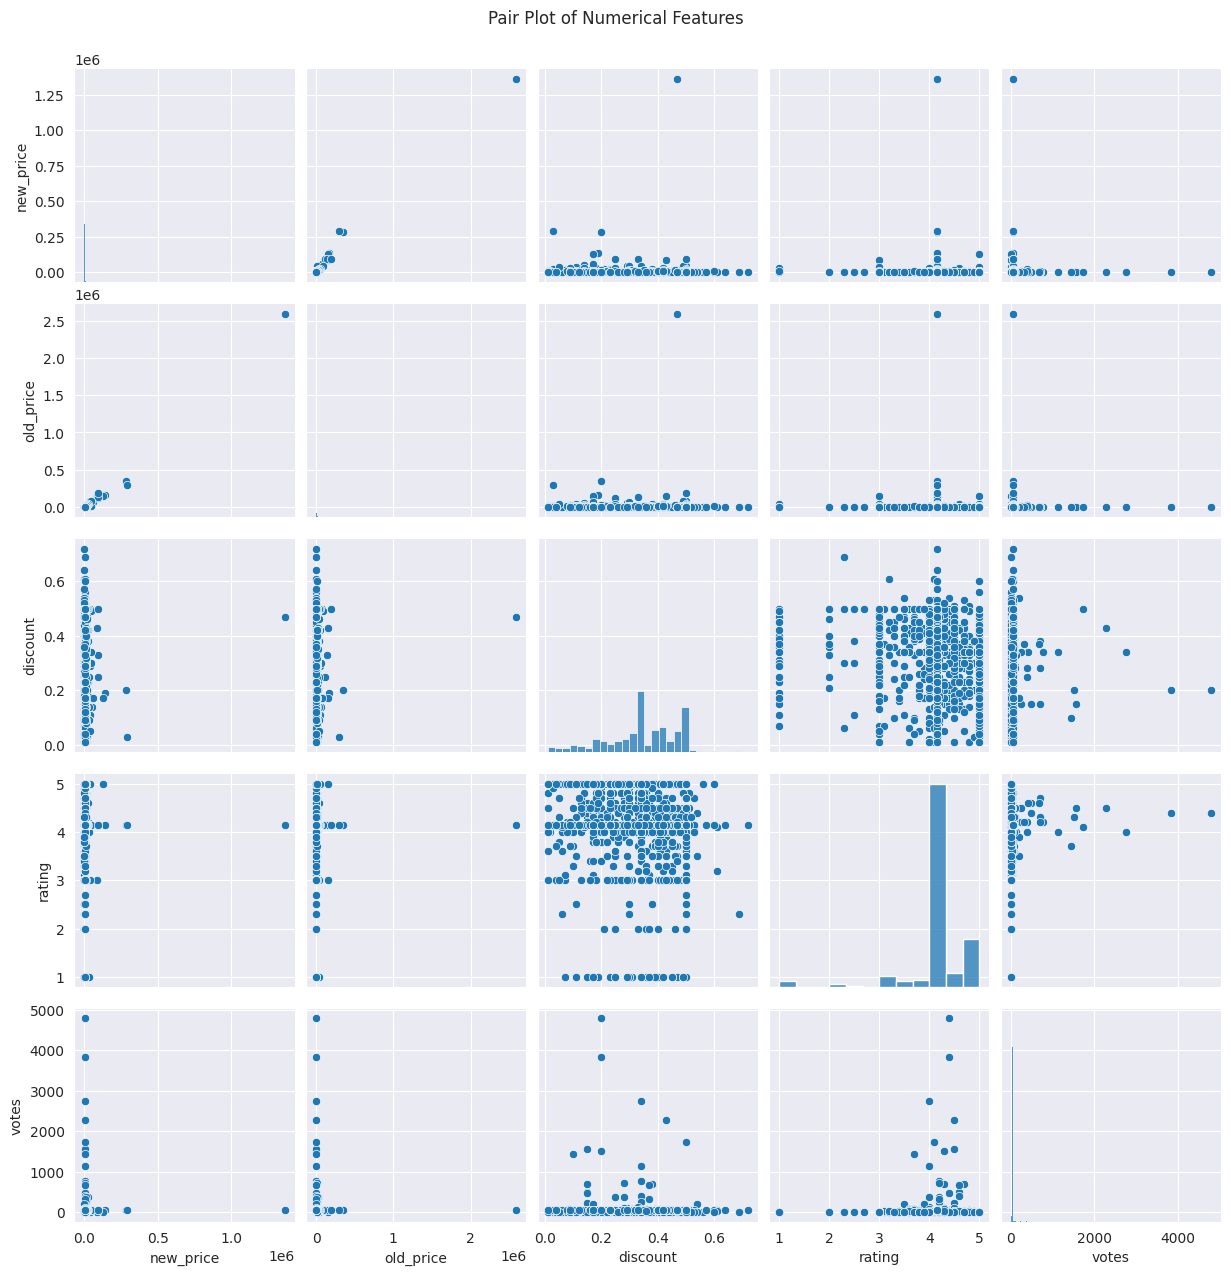

In [330]:
sns.pairplot(products_clean_df)
plt.suptitle('Pair Plot of Numerical Features', y=1.02)

# Save to file
plt.savefig("../results/plots/7_pairplot_rltnships_between_all_numerical_columns.png", bbox_inches="tight", pad_inches=1)